In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("antobenedetti/animals")

print("Path to dataset files:", path)

100%|██████████| 882M/882M [00:40<00:00, 23.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/antobenedetti/animals/versions/5


In [2]:
from torch import nn
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

In [18]:
transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [19]:
datasetsTrain = ImageFolder(root=path + "/animals/train",transform=transform)
datasetsTest = ImageFolder(root=path + "/animals/val",transform=transform)

In [20]:
trainloader = DataLoader(datasetsTrain, batch_size=32, shuffle=True)


In [6]:
class PathEmbedding(nn.Module) :
  def __init__ (self,image_size,path_size,embedding_size) :
    super().__init__()
    self.projection_layers = nn.Conv2d(in_channels=3,out_channels=embedding_size,
                                       kernel_size=path_size,stride=path_size)
    self.n_path = (image_size//path_size)**2


  def forward(self,x) :
    x = self.projection_layers(x)
    x = x.flatten(2)
    return x.transpose(1,2)

In [7]:
class PositionalEncoding (nn.Module) :
  def __init__ (self,embedding_size,n_path_size) :
    super().__init__()
    self.posencoding = nn.Parameter(torch.randn(1,n_path_size + 1,embedding_size))
    self.cls_token = nn.Parameter(torch.randn(1,1,embedding_size))
    self.embedding_size = embedding_size

  def forward(self,x) :
    batch = x.shape[0]
    cls_token = torch.broadcast_to(self.cls_token,(batch,1,self.embedding_size))
    x = torch.cat([cls_token,x],dim=1)
    return x + self.posencoding

In [10]:
path_em = PathEmbedding(244,24,64)
postencoding = PositionalEncoding(64,path_em.n_path)
with torch.no_grad() :
  data = torch.randn(1,3,244,244)
  t1 = path_em(data)
  t2 = postencoding(t1)
  print(t1.shape)
  print(t2.shape)

torch.Size([1, 100, 64])
torch.Size([1, 101, 64])


In [11]:
class LCM_Block (nn.Module) :
  def __init__ (self,d_model) :
    super().__init__()
    self.step1 = nn.Linear(d_model,d_model)
    self.step2 = nn.Linear(d_model,d_model)
    self.magnitude_layers = nn.Linear(d_model,d_model)
    self.gelu1 = nn.GELU(approximate='tanh')
    self.gelu2 = nn.GELU(approximate='tanh')
    self.tanh = nn.Tanh()
    self.layer_norm = nn.LayerNorm(d_model)

  def forward(self,x) :
    norm = self.layer_norm(x)
    step1 = self.gelu1(self.step1(norm))
    step2 = self.gelu2(self.step2(norm))
    laten = step1 + step2
    laten = self.magnitude_layers(laten)
    laten = self.tanh(laten)
    return x + laten

In [29]:
class LCM_Vision (nn.Module) :
  def __init__ (self,image_size : int,path_size : int ,embedding_size : int,num_block : int = 4,num_class : int = 5 ) :
    super().__init__()
    self.path_embedding = PathEmbedding(image_size,path_size,embedding_size=embedding_size)
    self.postEncoder = PositionalEncoding(embedding_size,self.path_embedding.n_path)
    self.LCMBlock = nn.ModuleList([LCM_Block(embedding_size) for _ in range(num_block)])
    self.linear = nn.Linear(embedding_size,num_class)


  def forward(self,x) :
    x = self.path_embedding(x)
    x = self.postEncoder(x)
    for layers in self.LCMBlock :
      x = layers(x)
    x = x.mean(dim=1)
    x = self.linear(x)
    return x

In [30]:
class TransformersBlock (nn.Module) :
  def __init__ (self,d_model,ffn_size,drop_rate):
    super().__init__()
    self.attn = nn.MultiheadAttention(d_model,4,batch_first=True,dropout=drop_rate)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.ffn =nn.Sequential(nn.Linear(d_model,ffn_size),
                            nn.GELU(approximate='tanh'),
                            nn.Linear(ffn_size,d_model))
    self.dropout = nn.Dropout(drop_rate)



  def forward(self,x) :
    norm1 = self.norm1(x)
    attn,_ = self.attn(norm1,norm1,norm1)
    x = x + attn

    norm2 = self.norm2(x)
    ffn = self.ffn(norm2)
    ffn = self.dropout(ffn)
    x = x+ffn
    return x


In [31]:
class VIT (nn.Module) :
  def __init__ (self,image_size,path_size,embedding_size,drop_rate,num_block,num_class) :
    super().__init__()
    self.path_embedding = PathEmbedding(image_size,path_size,embedding_size=embedding_size)
    self.postEncoder = PositionalEncoding(embedding_size,self.path_embedding.n_path)
    self.transformersBlock = nn.ModuleList([TransformersBlock(embedding_size,embedding_size,drop_rate) for _ in range(num_block)])
    self.linear = nn.Linear(embedding_size,num_class)


  def forward(self,x) :
    x = self.path_embedding(x)
    x = self.postEncoder(x)
    for layers in self.transformersBlock :
      x = layers(x)
    x = x.mean(dim=1)
    return self.linear(x)

In [ ]:
datasetsTrain.class_to_idx

{'cat': 0, 'dog': 1, 'elephant': 2, 'horse': 3, 'lion': 4}

In [32]:
LcmVision = LCM_Vision(244,path_size=24,embedding_size=128)
LcmVision.to('cuda')
LcmVision.train(True)


VIT(
  (path_embedding): PathEmbedding(
    (projection_layers): Conv2d(3, 128, kernel_size=(24, 24), stride=(24, 24))
  )
  (postEncoder): PositionalEncoding()
  (transformersBlock): ModuleList(
    (0-3): 4 x TransformersBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): GELU(approximate='tanh')
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (linear): Linear(in_features=128, out_features=5, bias=True)
)

In [44]:

Vit = VIT(244,path_size=24,embedding_size=128,drop_rate=0.1,num_block=4,num_class=5)
Vit.to('cuda')
Vit.train(True)

VIT(
  (path_embedding): PathEmbedding(
    (projection_layers): Conv2d(3, 128, kernel_size=(24, 24), stride=(24, 24))
  )
  (postEncoder): PositionalEncoding()
  (transformersBlock): ModuleList(
    (0-3): 4 x TransformersBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): GELU(approximate='tanh')
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (linear): Linear(in_features=128, out_features=5, bias=True)
)

In [22]:
from tqdm import tqdm

In [33]:
optimizer_fn = torch.optim.AdamW(LcmVision.parameters())
loss_fn = nn.CrossEntropyLoss()
lcm_loss_train = list()
lcm_val_loss = list()

In [24]:
loadtest = DataLoader(datasetsTest,batch_size=32,shuffle=True)

In [36]:
epochs = 1
for epoch in range(epochs) :
  total_loss = 0
  inisiator_data = tqdm(trainloader)
  for image,label in inisiator_data :
    image = image.to('cuda')
    label = label.to('cuda')
    y_pred = LcmVision(image)
    loss = loss_fn(y_pred,label)
    optimizer_fn.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(LcmVision.parameters(),1.0)
    optimizer_fn.step()
    inisiator_data.set_description(f"Epoch {epoch+1}/{epochs}")
    inisiator_data.set_postfix(loss=loss.item())
    total_loss += loss.item()
  lcm_loss_train.append(total_loss/len(trainloader))
  with torch.no_grad() :
    total_loss_val = 0
    for image,label in loadtest :
      image = image.to('cuda')
      label = label.to('cuda')
      y_pred = LcmVision(image)
      loss = loss_fn(y_pred,label)
      total_loss_val += loss.item()
    lcm_val_loss.append(total_loss_val/len(loadtest))
    print(f"[epoch : {epoch + 1} / {epochs} || loss : {total_loss/len(trainloader)} || vall_loss : {total_loss_val/len(loadtest)}]")


Epoch 1/1: 100%|██████████| 422/422 [01:11<00:00,  5.94it/s, loss=0.000885]


[epoch : 1 / 1 || loss : 0.201543530260717 || vall_loss : 0.7146471821247263]


In [38]:
import matplotlib.pyplot as plt


[]

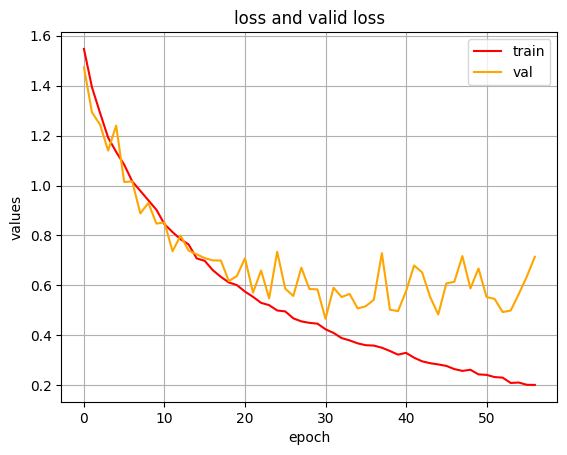

In [39]:
plt.title("loss and valid loss")
plt.xlabel("epoch")
plt.ylabel("values")
plt.plot(lcm_loss_train,label="train",color='red')
plt.plot(lcm_val_loss,label="val",color='orange')
plt.legend()
plt.grid(True)
plt.plot()

In [53]:
optimizer_fn = torch.optim.AdamW(Vit.parameters())
loss_fn = nn.CrossEntropyLoss()
vitloss_train = list()
vit_val_loss = list()

In [55]:
epochs = 1
for epoch in range(epochs) :
  total_loss = 0
  inisiator_data = tqdm(trainloader)
  for image,label in inisiator_data :
    image = image.to('cuda')
    label = label.to('cuda')
    y_pred = Vit(image)
    loss = loss_fn(y_pred,label)
    optimizer_fn.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(Vit.parameters(),1.0)
    optimizer_fn.step()
    inisiator_data.set_description(f"Epoch {epoch+1}/{epochs}")
    inisiator_data.set_postfix(loss=loss.item())
    total_loss += loss.item()
  vitloss_train.append(total_loss/len(trainloader))
  with torch.no_grad() :
    total_loss_val = 0
    for image,label in loadtest :
      image = image.to('cuda')
      label = label.to('cuda')
      y_pred = Vit(image)
      loss = loss_fn(y_pred,label)
      total_loss_val += loss.item()
    vit_val_loss.append(total_loss_val/len(loadtest))
    print(f"[epoch : {epoch + 1} / {epochs} || loss : {total_loss/len(trainloader)} || vall_loss : {total_loss_val/len(loadtest)}]")


Epoch 1/1: 100%|██████████| 422/422 [01:13<00:00,  5.71it/s, loss=9.54e-6]


[epoch : 1 / 1 || loss : 0.19790776486169526 || vall_loss : 0.9341514066178748]


[]

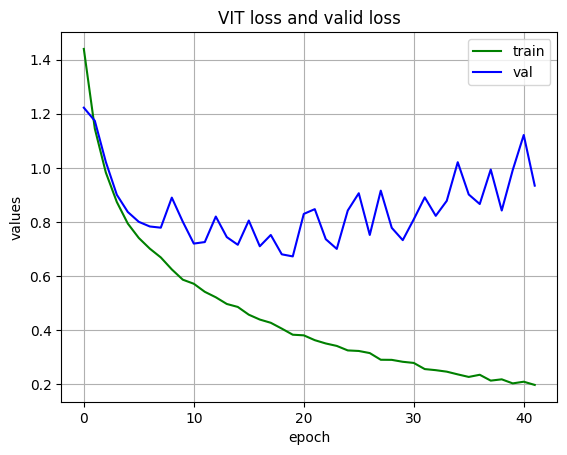

In [56]:
plt.title("VIT loss and valid loss")
plt.xlabel("epoch")
plt.ylabel("values")
plt.plot(vitloss_train,label="train",color='green')
plt.plot(vit_val_loss,label="val",color='blue')
plt.legend()
plt.grid(True)
plt.plot()